# 股指期货跨期套利策略探索

李林轩 202506

跨期套利是指在同一市场中利用标的相同、交割月份不同的期货合约进行长短期套利的策略，其本质上类似一种风险对冲。股指期货跨期套利是指同时买入和卖出同一品种但不同交割月份的股指期货合约，以期在未来两种不同交割月份的期货合约价格涨幅不一致时（即价差如预期那样扩大或缩小时），进而对冲合约获取利润。

股指期货各个合约对应的标的均为股票指数，存在一定的长期相关性。在中国市场上，股指期货（在中国金融期货交易所交易）主要有四种，分别是IF（沪深300）、IH（中证500）、IC（上证50）、IM（中证1000），每个股指期货合约对应不同的交割月份，每个品种有四个不同的合约到期日，分别为本月（00）、下月（01）、本季（02）、下季（03）。因此，每个品种的四个合约就可以组合出六个不同的跨期价差。

实际当中，由于现金交割、季节性特征不明显等特点，股指期货跨期套利的机会主要集中在股指期货移仓换季时，同时当存在指数分红预期、合约流动性、市场情绪等因素进，各个合约常常出现收益率的背离，在极端行情中也存在低风险套利机会。当期货深度贴水时、基差较高时，空头将主动移仓，从而压低次季合约价格，提高当季合约价格，导致跨期价差出现上行，从而产生跨期套利机会。同时当市场预期较为悲观时，远月合约会相对弱势，也会产生跨期套利机会。

In [93]:
# 导入需要的包
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False 
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import os
import cointegration_analysis

## （一）合约间价差关系分析

In [90]:
# 导入数据，处理单个期货品种的价差
def process_futures_data(futures_type):
    """
    处理指定品种的期货价差数据
    
    参数:
        futures_type (str): 期货品种，如 'if', 'ih', 'ic', 'im'
    
    返回:
        pd.DataFrame: 处理后的价差数据
    """
    # 读取数据
    df0 = pd.read_csv(f'data/{futures_type.upper()}00.csv')
    df1 = pd.read_csv(f'data/{futures_type.upper()}01.csv')
    df2 = pd.read_csv(f'data/{futures_type.upper()}02.csv')
    df3 = pd.read_csv(f'data/{futures_type.upper()}03.csv')
    
    # 选择需要的列并重命名
    dfs = []
    for i, df in enumerate([df0, df1, df2, df3]):
        df_selected = df[['trade_date', 'close']].rename(
            columns={'close': f'close_{futures_type}{i}'}
        )
        dfs.append(df_selected)
    
    # 合并数据
    merged_df = dfs[0]
    for df in dfs[1:]:
        merged_df = pd.merge(merged_df, df, on='trade_date', how='inner')
    
    # 计算价差
    for i in range(3):
        for j in range(i+1, 4):
            col_name = f'price_spread_{futures_type}{i}_{futures_type}{j}'
            merged_df[col_name] = merged_df[f'close_{futures_type}{i}'] - merged_df[f'close_{futures_type}{j}']
    
    # 转换日期格式
    merged_df['trade_date'] = pd.to_datetime(merged_df['trade_date'], format='%Y%m%d')
    
    return merged_df

# 处理所有期货品种的数据（取消注释可看描述统计）
def process_all_futures():
    """处理所有期货品种的数据"""
    futures_types = ['if', 'ih', 'ic', 'im']
    results = {}
    
    for ft in futures_types:
        # print(f"正在处理{ft.upper()}数据...")
        try:
            df = process_futures_data(ft)
            results[ft] = df
            # print(f"{ft.upper()}描述统计:")
            # print(df.describe())
            # 保存到CSV
            df.to_csv(f'data/{ft}_spread.csv', index=False)
            print(f"{ft.upper()}数据已保存到 data/{ft}_spread.csv\n")
        except Exception as e:
            print(f"处理{ft.upper()}数据时出错: {e}\n")
    
    return results

process_all_futures()

IF数据已保存到 data/if_spread.csv

IH数据已保存到 data/ih_spread.csv

IC数据已保存到 data/ic_spread.csv

IM数据已保存到 data/im_spread.csv



{'if':      trade_date  close_if0  close_if1  close_if2  close_if3  price_spread_if0_if1  price_spread_if0_if2  price_spread_if0_if3  price_spread_if1_if2  price_spread_if1_if3  price_spread_if2_if3
 0    2025-05-30     3822.4     3785.6     3752.0     3715.2                  36.8                  70.4                 107.2                  33.6                  70.4                  36.8
 1    2025-05-29     3832.8     3797.6     3767.2     3732.8                  35.2                  65.6                 100.0                  30.4                  64.8                  34.4
 2    2025-05-28     3805.0     3766.2     3735.2     3696.8                  38.8                  69.8                 108.2                  31.0                  69.4                  38.4
 3    2025-05-27     3809.2     3771.4     3740.0     3707.2                  37.8                  69.2                 102.0                  31.4                  64.2                  32.8
 4    2025-05-26     3831.2  

正在生成 IF 的价差图...


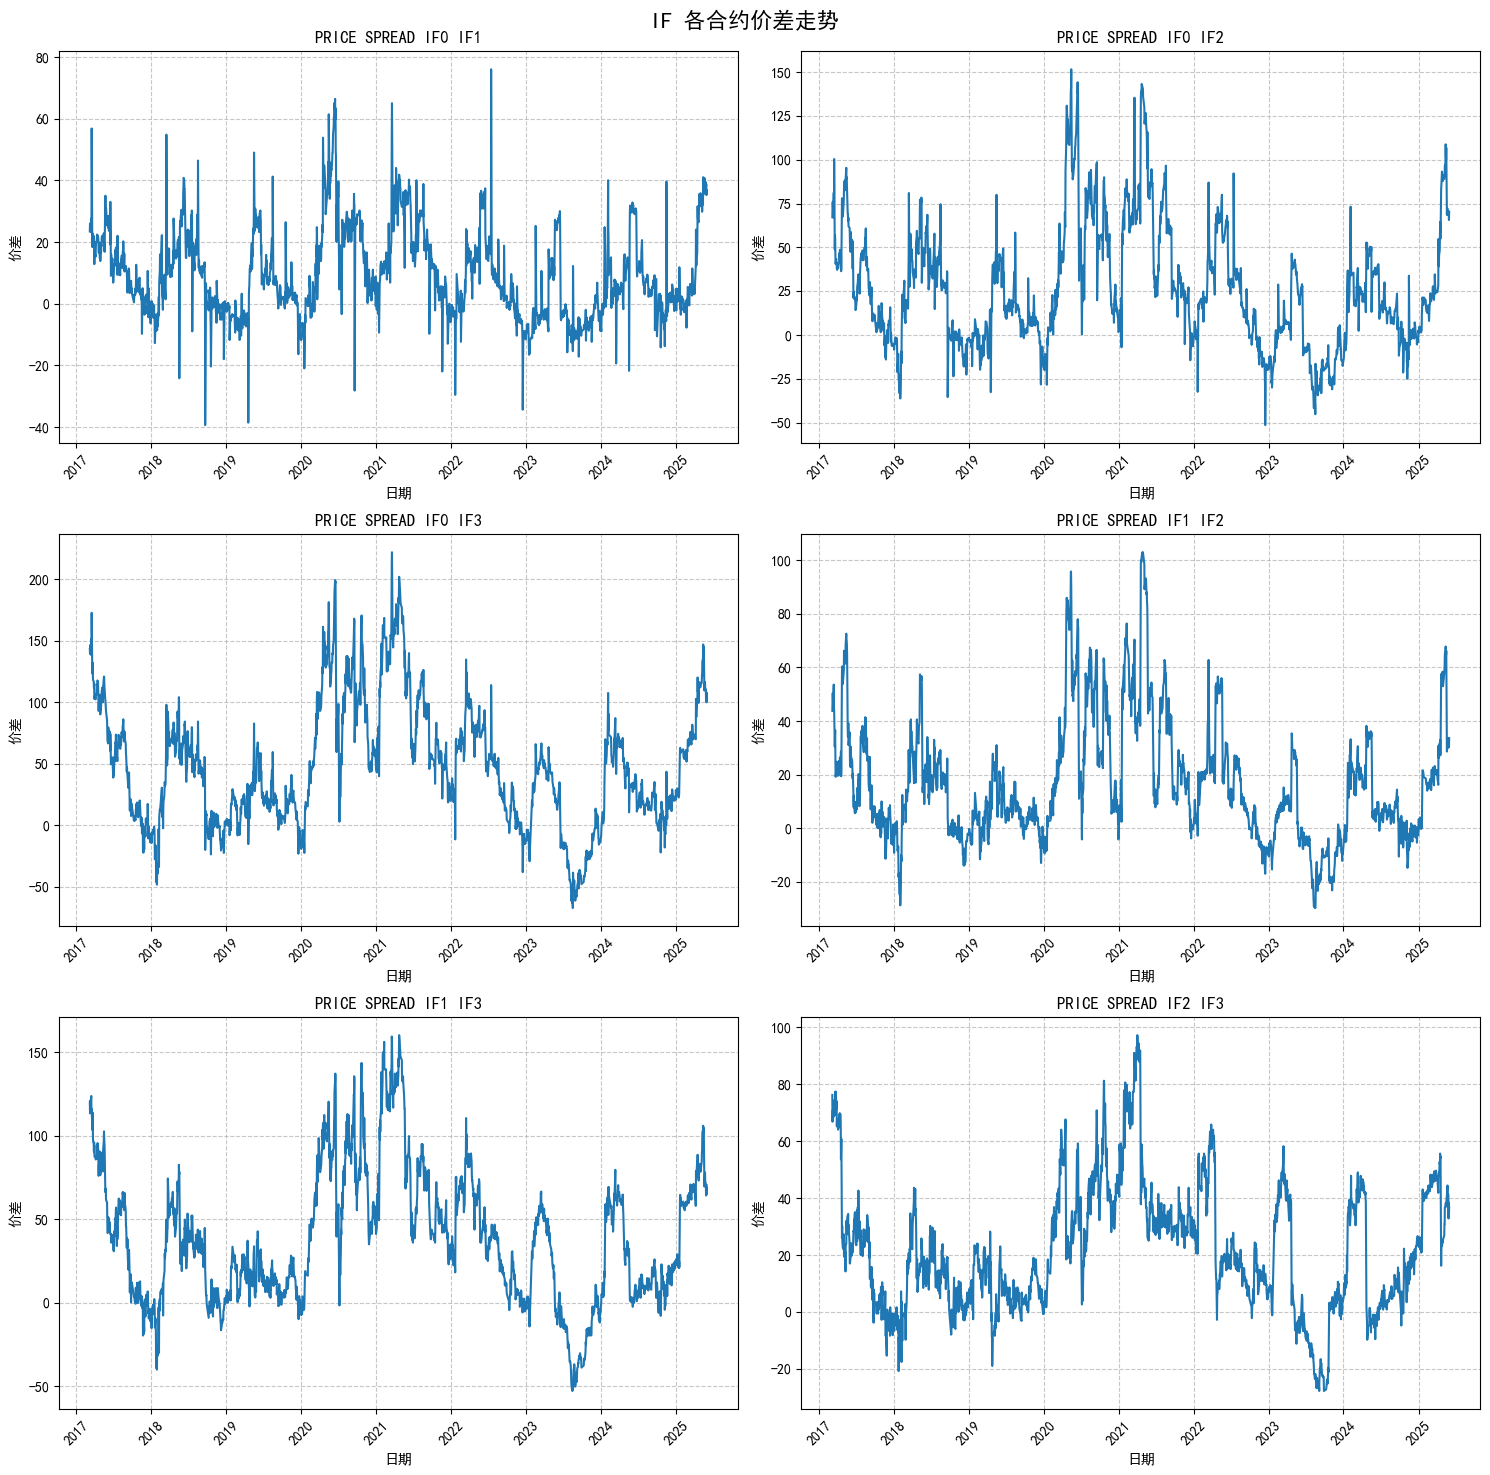

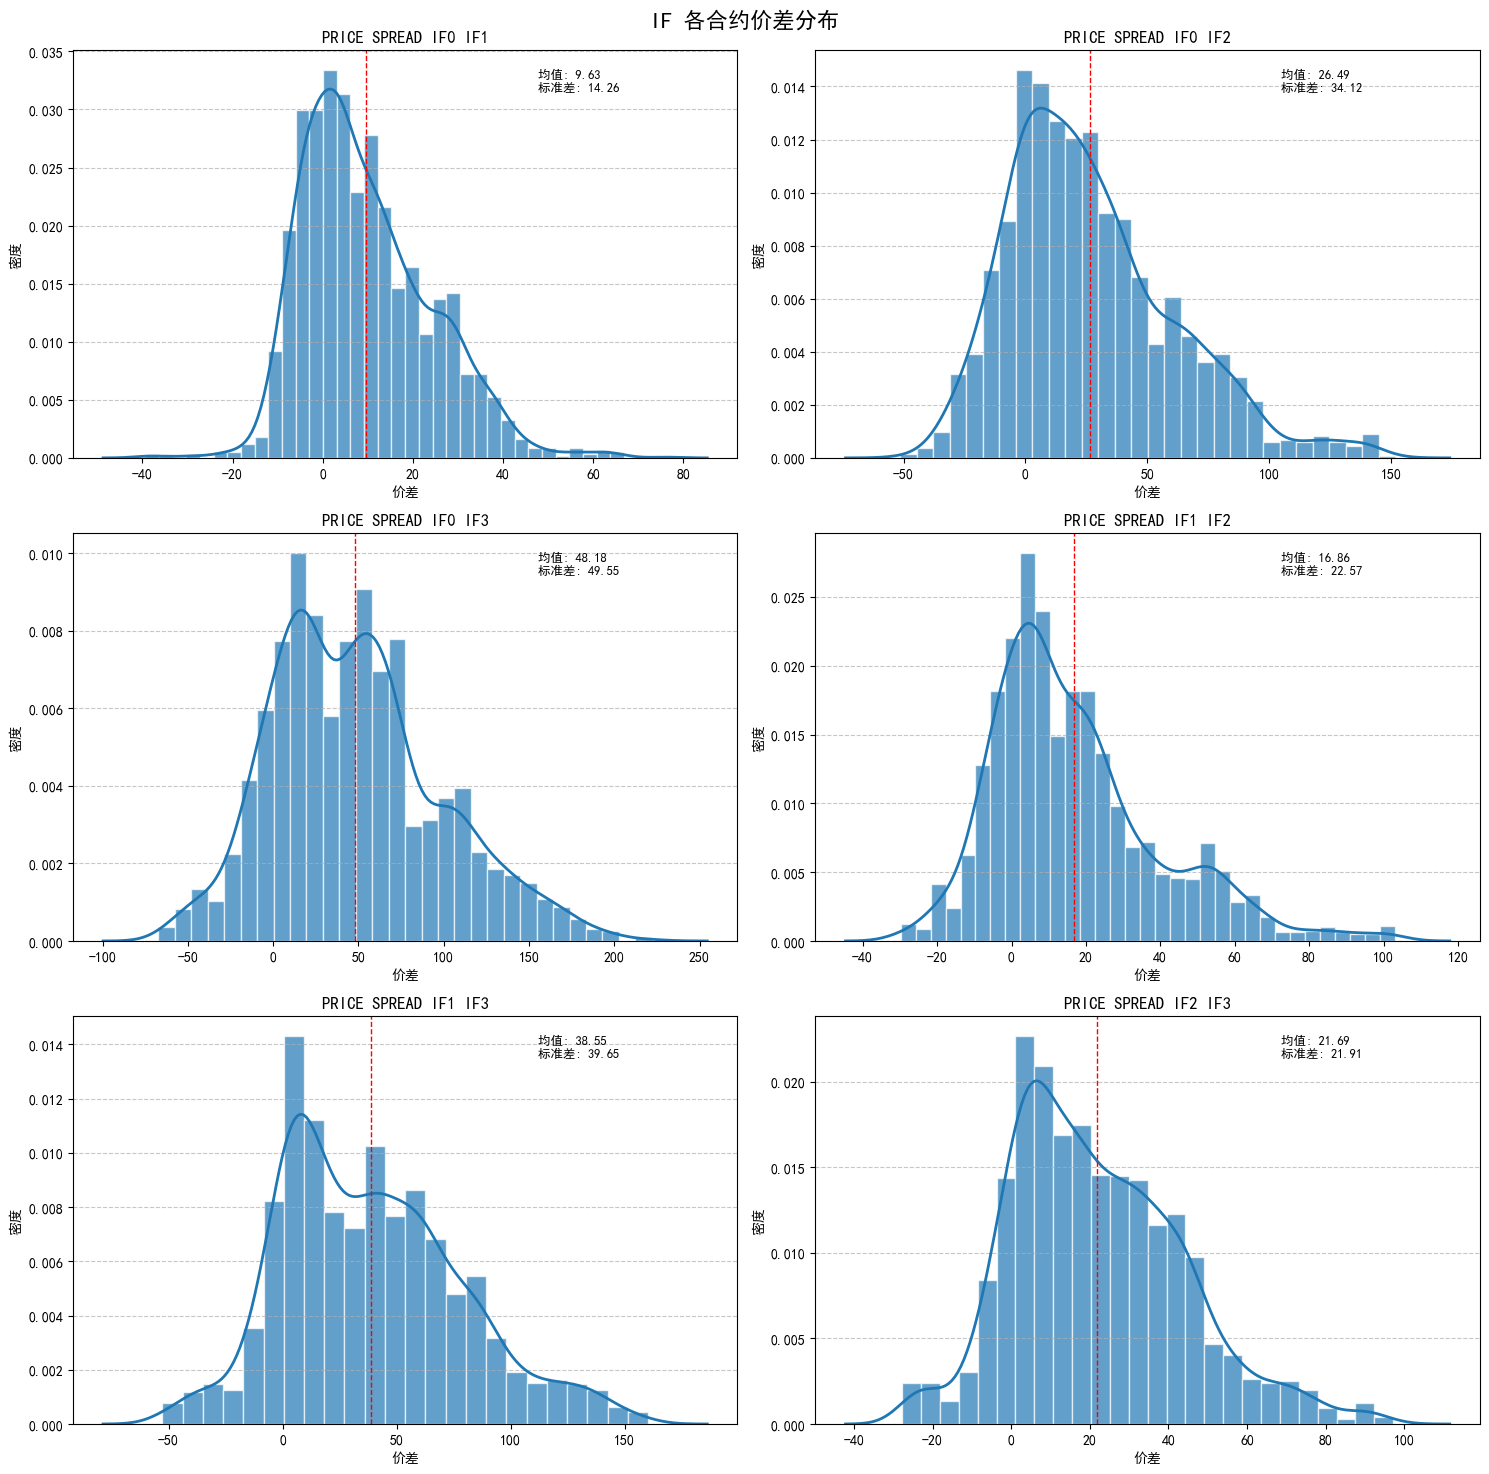

正在生成 IH 的价差图...


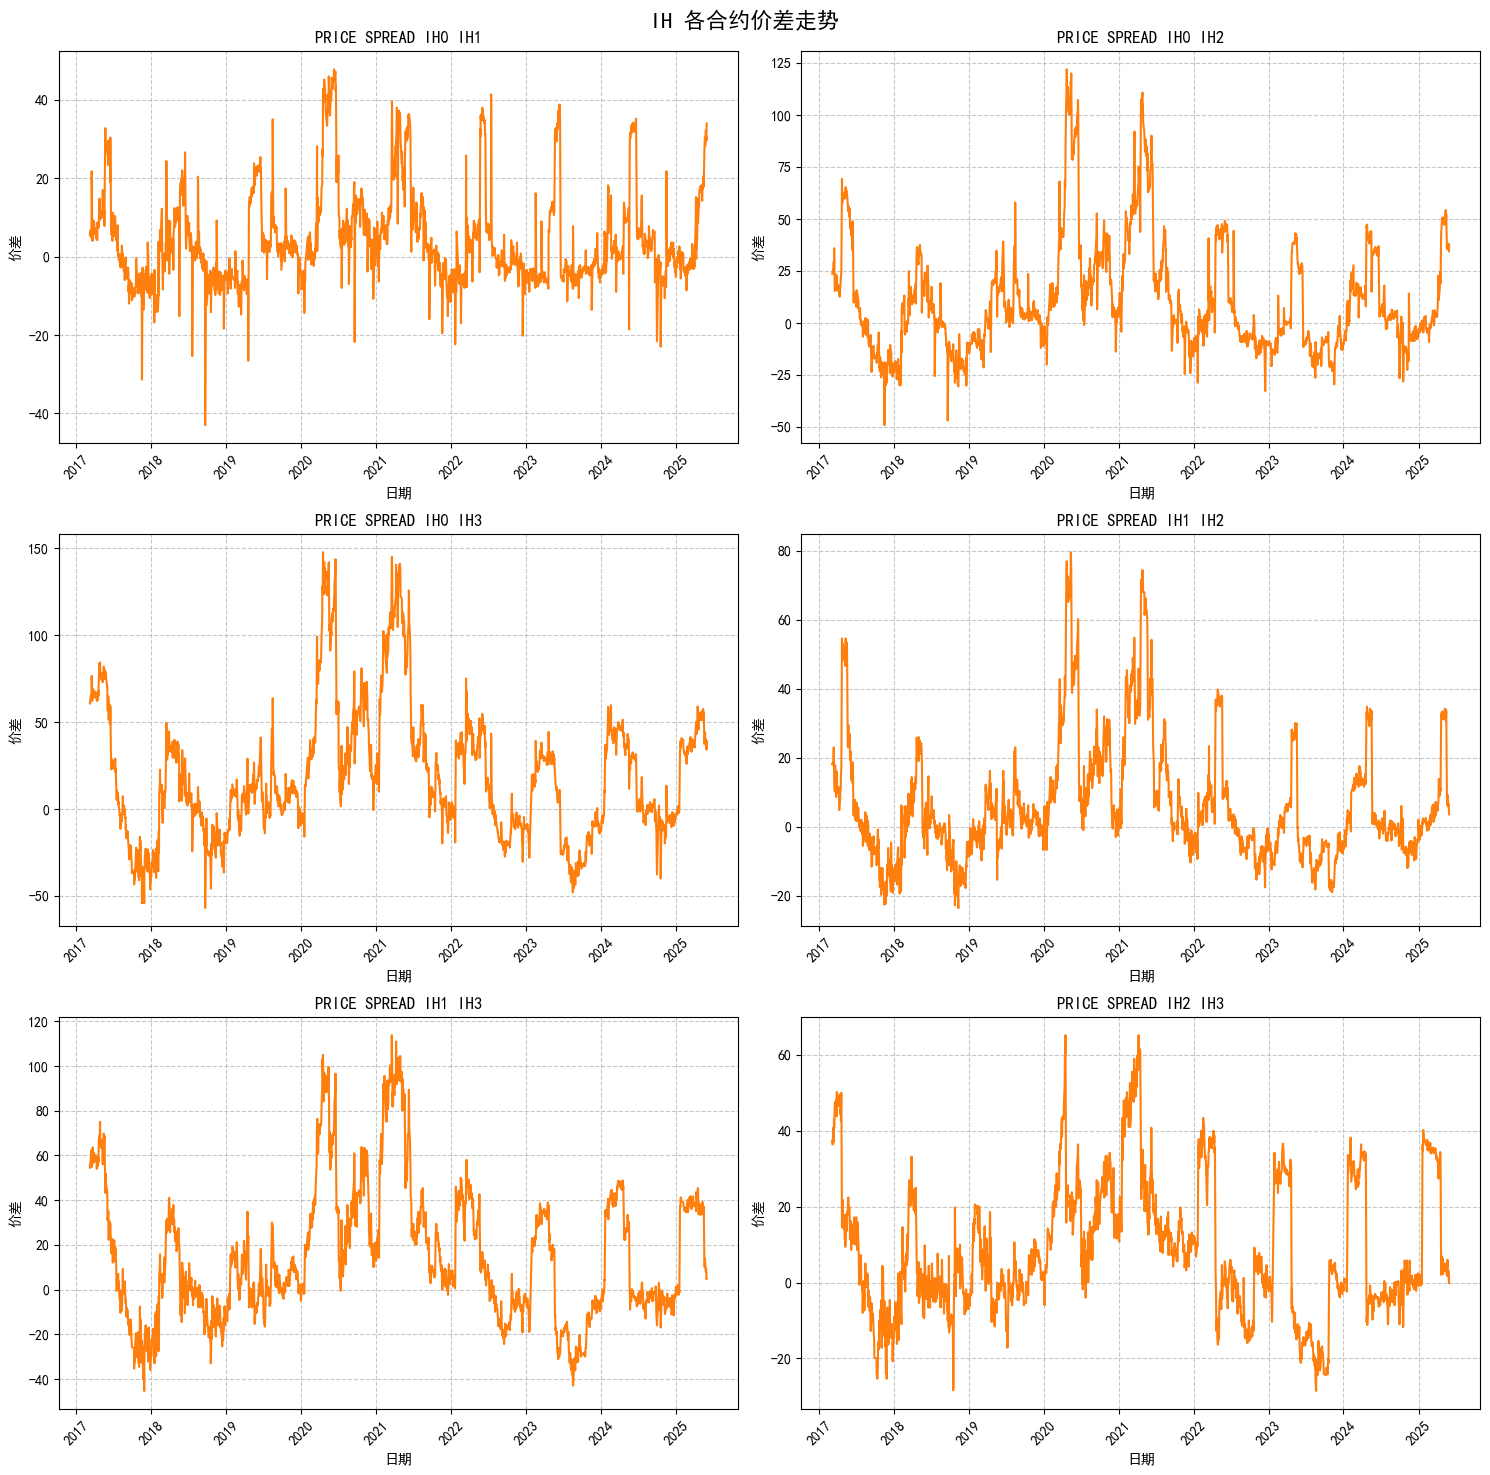

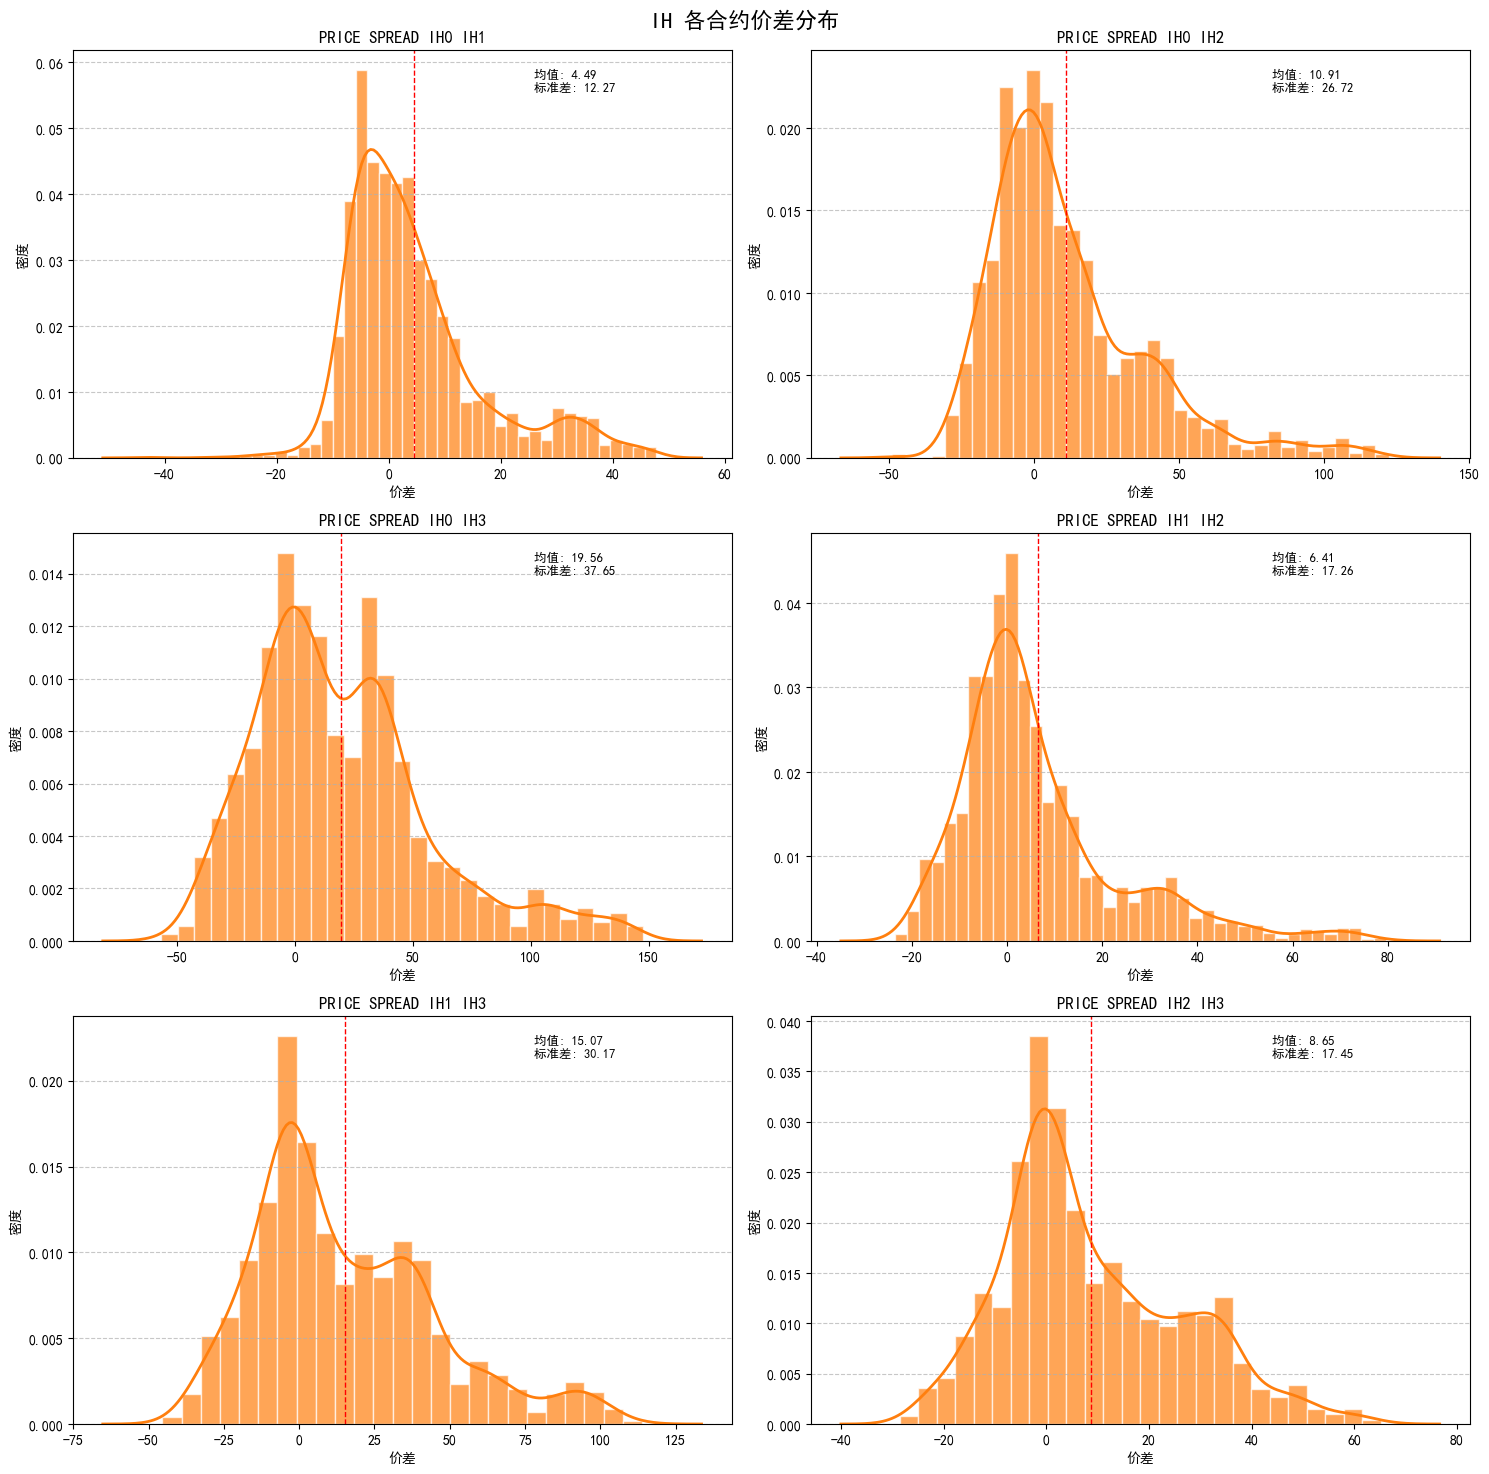

正在生成 IC 的价差图...


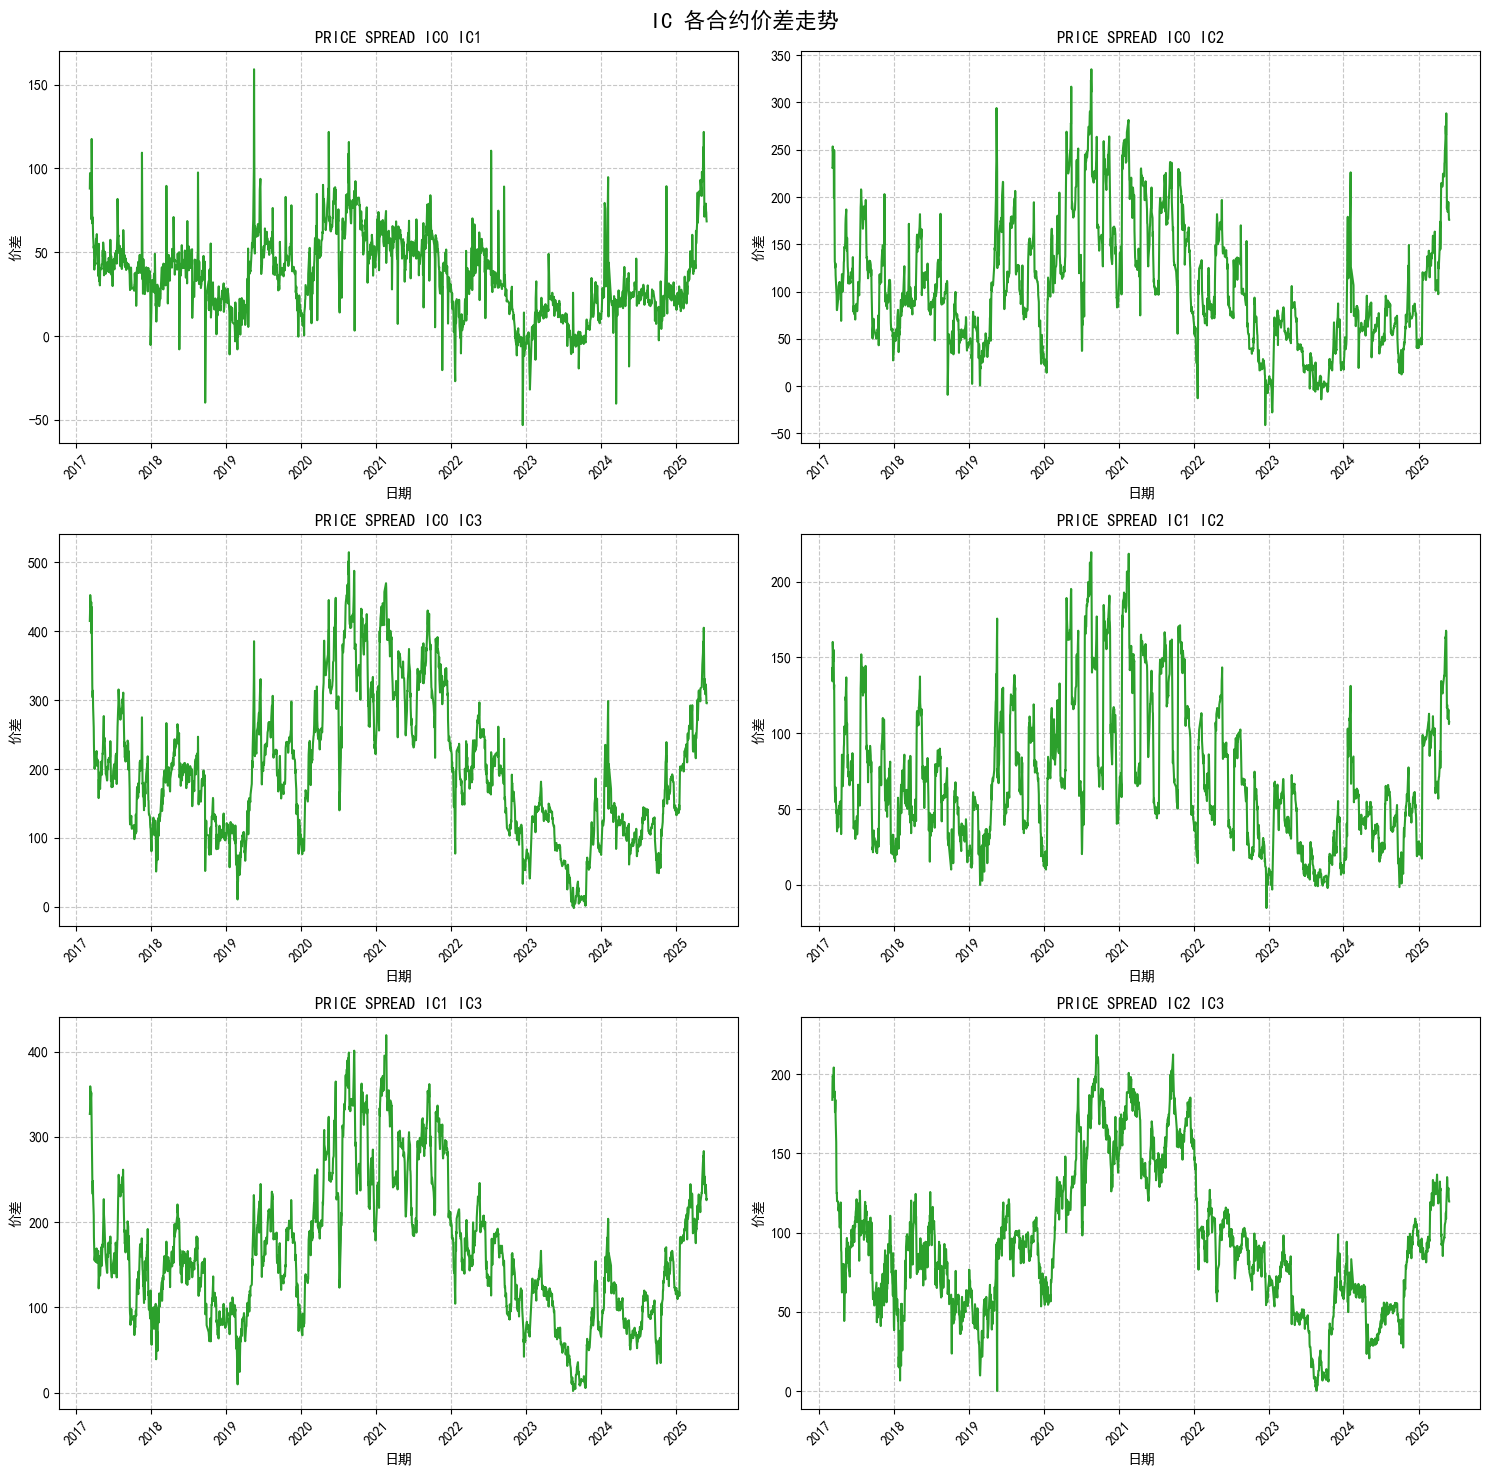

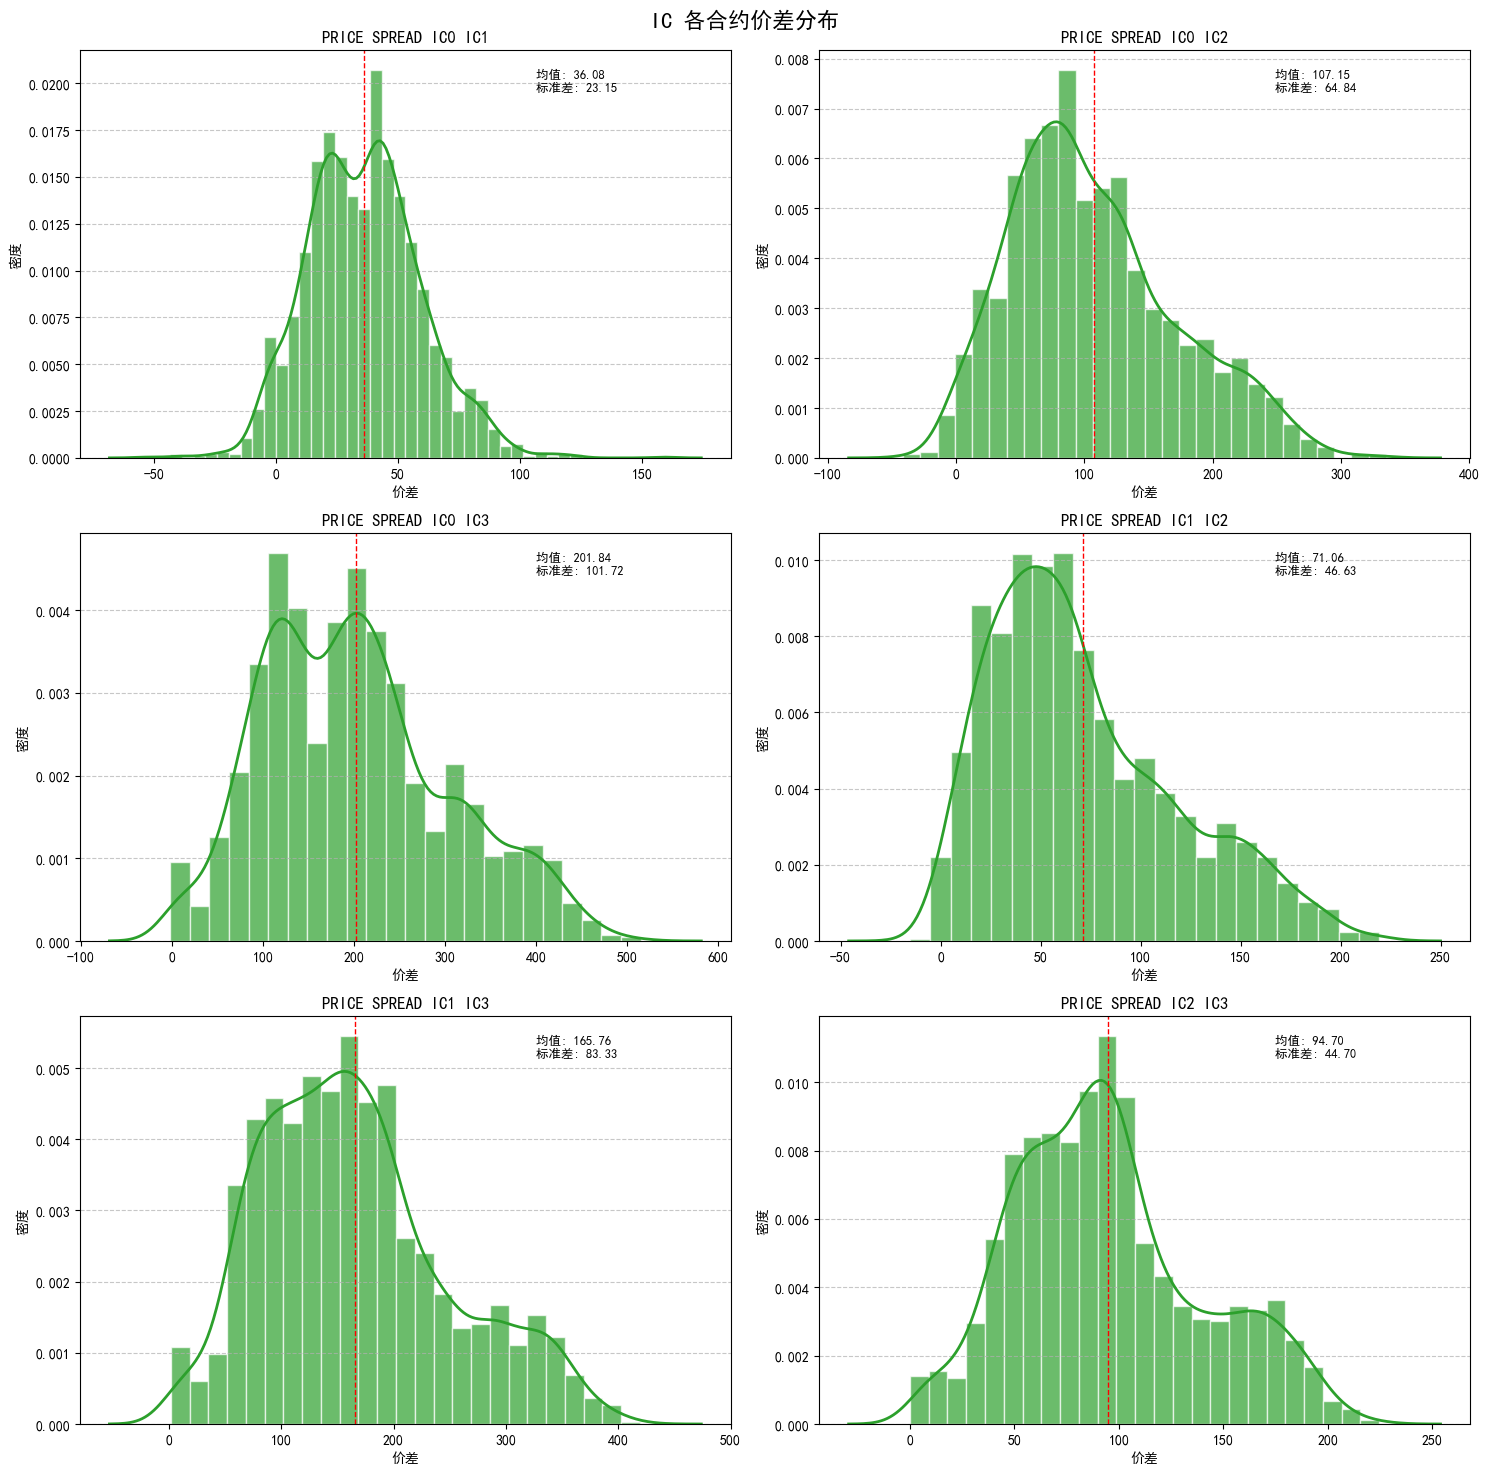

正在生成 IM 的价差图...


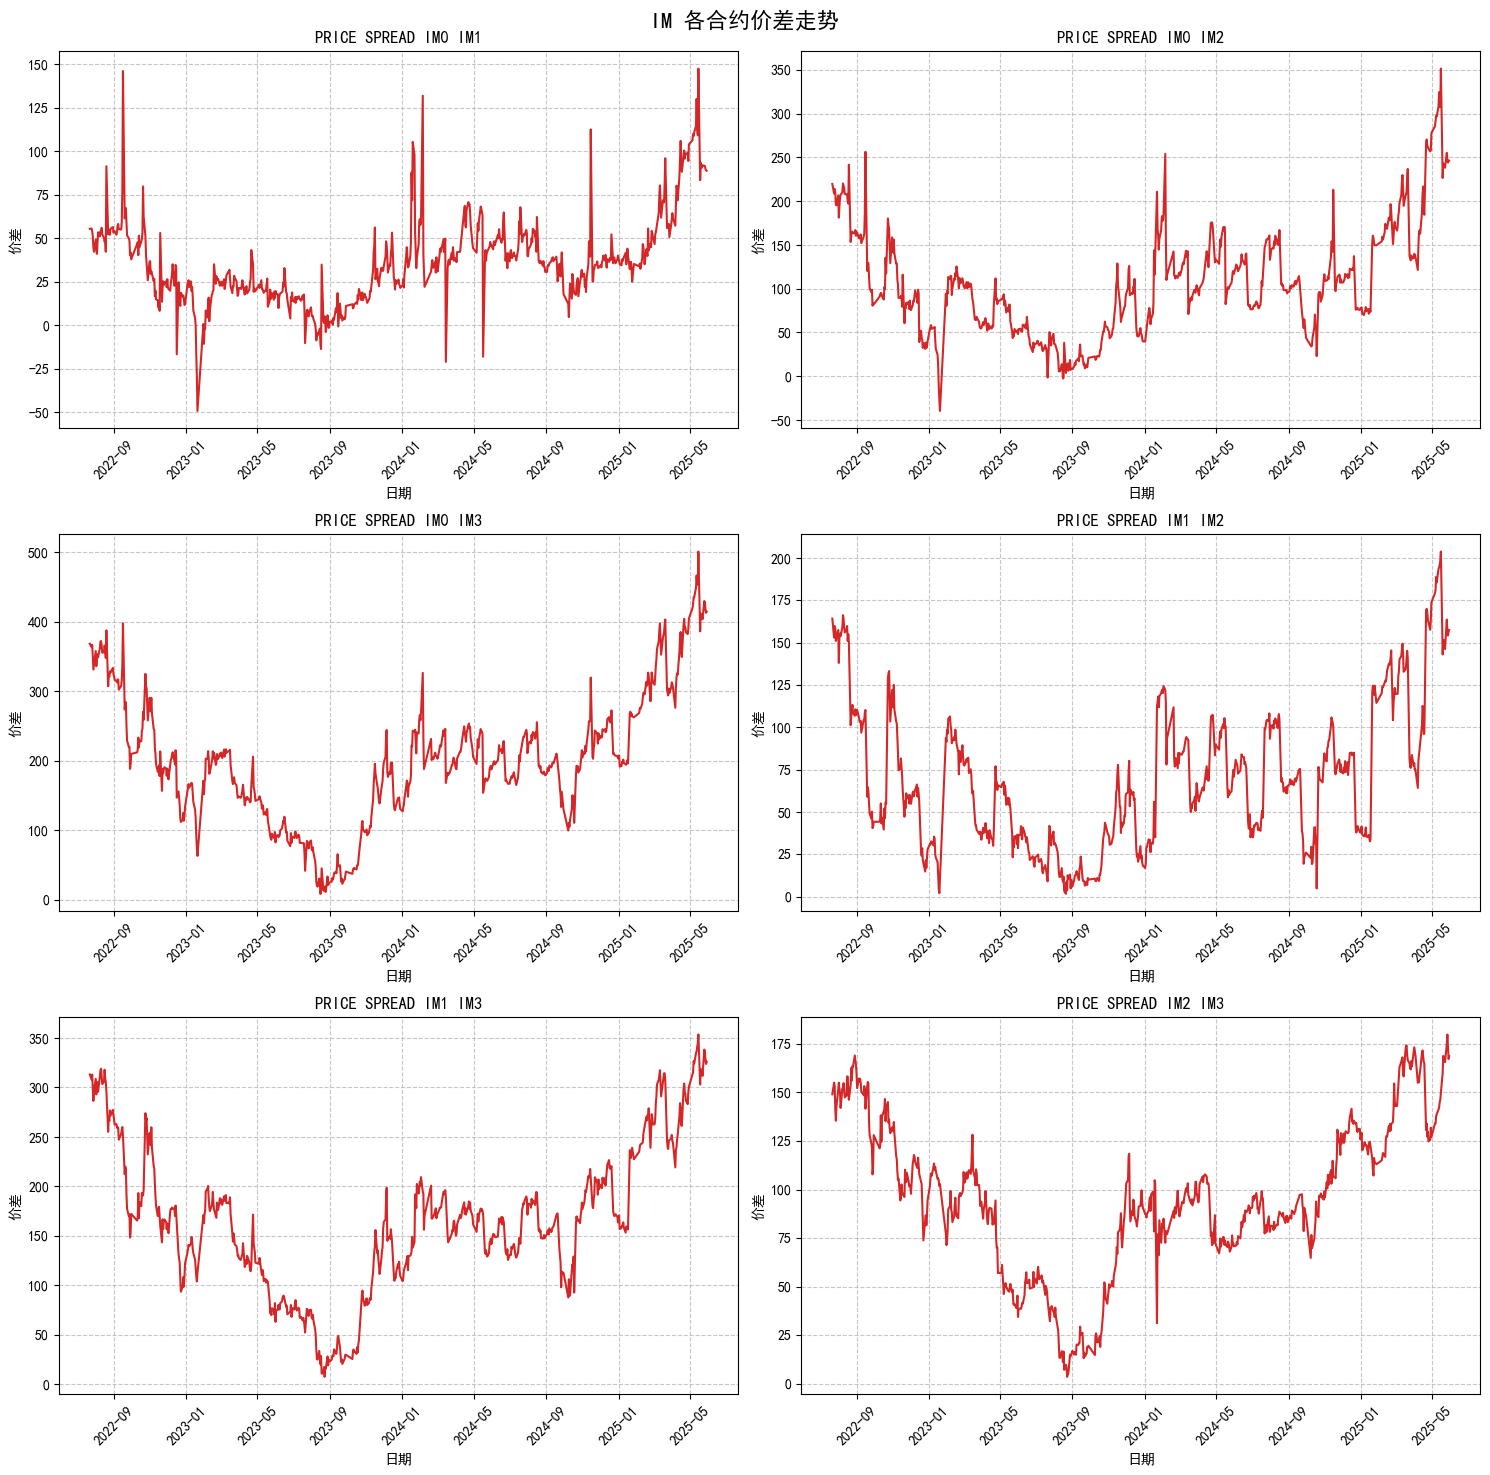

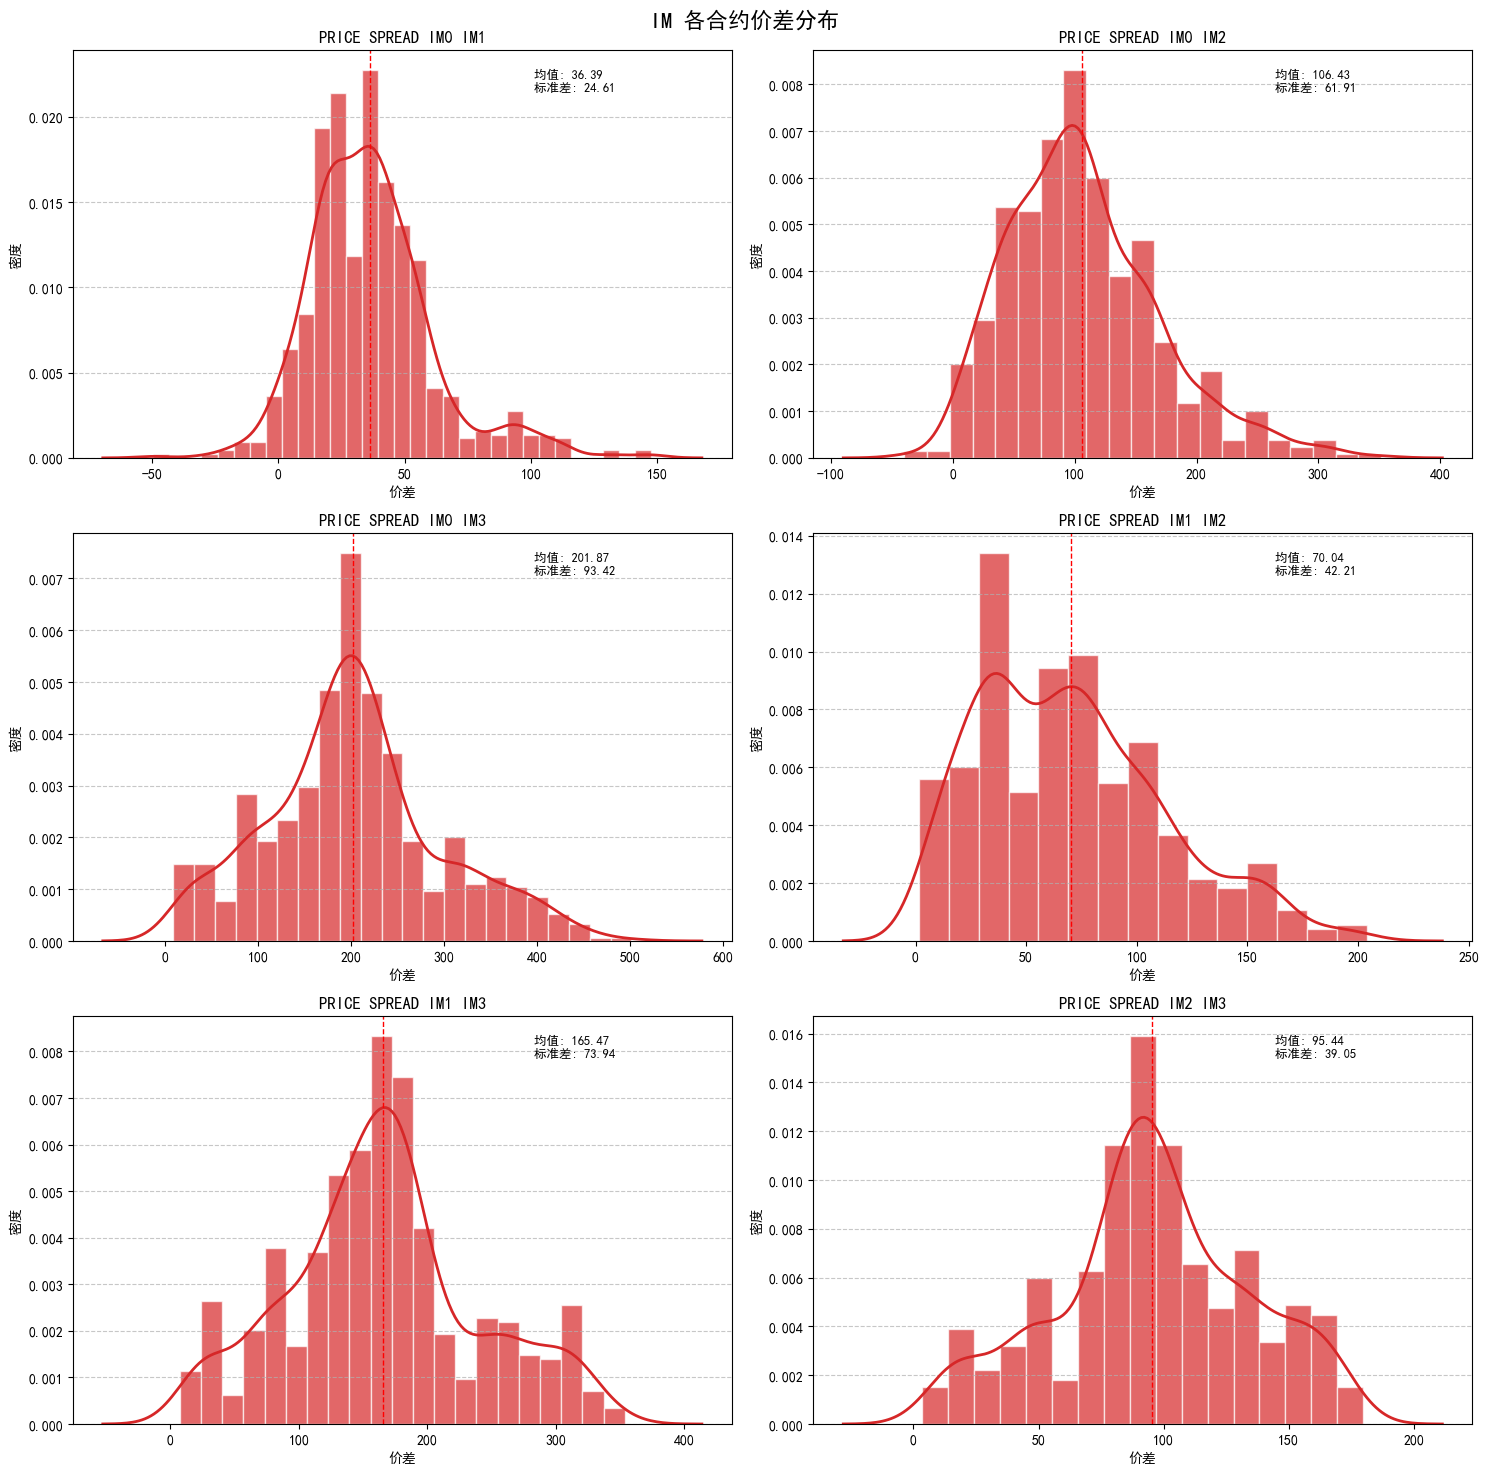

In [91]:
def load_futures_data(futures_type):
    """加载期货数据"""
    file_path = f"data/{futures_type.lower()}_spread.csv"
    if not os.path.exists(file_path):
        print(f"文件 {file_path} 不存在，请先运行 process_futures.py 生成数据")
        return None
    df = pd.read_csv(file_path)
    df['trade_date'] = pd.to_datetime(df['trade_date'])
    return df

# 定义不同期货品种的颜色
FUTURES_COLORS = {
    'if': '#1f77b4',  # 蓝色
    'ih': '#ff7f0e',  # 橙色
    'ic': '#2ca02c',  # 绿色
    'im': '#d62728'   # 红色
}

def plot_futures_spreads(futures_type):
    """绘制指定品种的价差图"""
    df = load_futures_data(futures_type)
    if df is None:
        return
    
    # 获取所有价差列
    spread_cols = [col for col in df.columns if col.startswith('price_spread')]
    if not spread_cols:
        print(f"未找到 {futures_type} 的价差数据列")
        return
    
    # 创建子图
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    fig.suptitle(f'{futures_type.upper()} 各合约价差走势', fontsize=16)
    
    # 获取当前品种的颜色
    color = FUTURES_COLORS.get(futures_type.lower(), '#1f77b4')  # 默认蓝色
    
    # 展平axes数组以便于迭代
    axes = axes.flatten()
    
    # 绘制每个价差
    for i, col in enumerate(spread_cols):
        if i >= len(axes):  # 防止数组越界
            break
            
        ax = axes[i]
        ax.plot(df['trade_date'], df[col], 
                label=col.replace('_', ' ').upper(),
                color=color,
                linewidth=1.5)
        ax.set_title(f'{col.replace("_", " ").upper()}')
        ax.set_xlabel('日期')
        ax.set_ylabel('价差')
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.tick_params(axis='x', rotation=45)
    
    # 如果子图数量不是6的倍数，隐藏多余的子图
    for j in range(len(spread_cols), len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.savefig(f'fig/{futures_type.lower()}_spreads.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_futures_distributions(futures_type):
    """绘制指定品种的价差分布直方图"""
    df = load_futures_data(futures_type)
    if df is None:
        return
    
    # 获取所有价差列
    spread_cols = [col for col in df.columns if col.startswith('price_spread')]
    if not spread_cols:
        print(f"未找到 {futures_type} 的价差数据列")
        return
    
    # 创建子图
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    fig.suptitle(f'{futures_type.upper()} 各合约价差分布', fontsize=16)
    
    # 获取当前品种的颜色
    color = FUTURES_COLORS.get(futures_type.lower(), '#1f77b4')  # 默认蓝色
    
    # 展平axes数组以便于迭代
    axes = axes.flatten()
    
    # 绘制每个价差的分布
    for i, col in enumerate(spread_cols):
        if i >= len(axes):  # 防止数组越界
            break
            
        ax = axes[i]
        ax.hist(df[col], 
                bins='auto', 
                color=color, 
                edgecolor='white', 
                alpha=0.7,
                density=True)  # 显示密度而不是计数
        
        # 添加核密度估计(KDE)曲线
        import seaborn as sns
        sns.kdeplot(df[col].dropna(), color=color, ax=ax, linewidth=2)
        
        ax.set_title(f'{col.replace("_", " ").upper()}')
        ax.set_xlabel('价差')
        ax.set_ylabel('密度')
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # 添加均值和标准差标注
        mean = df[col].mean()
        std = df[col].std()
        ax.axvline(mean, color='red', linestyle='dashed', linewidth=1)
        ax.text(0.7, 0.9, f'均值: {mean:.2f}\n标准差: {std:.2f}',
                transform=ax.transAxes, fontsize=9)
    
    # 如果子图数量不是6的倍数，隐藏多余的子图
    for j in range(len(spread_cols), len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.savefig(f'fig/{futures_type.lower()}_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_all_futures_spreads():
    """绘制所有期货品种的价差图"""
    futures_types = ['if', 'ih', 'ic', 'im']
    
    for ft in futures_types:
        print(f"正在生成 {ft.upper()} 的价差图...")
        plot_futures_spreads(ft)
        plot_futures_distributions(ft)

plot_all_futures_spreads()

## 协整（价差平稳性）检验

ADF(Augmented Dickey-Fuller Test) 检验是一种单位根检验 (Unit Root Test)。单位根是导致序列非平稳的一个常见原因。

原假设 (H0)：时间序列具有单位根（即非平稳）。

备择假设 (H1)：时间序列没有单位根（即平稳或趋势平稳）。

如果检验结果的 p 值小于显著性水平（例如 0.05），则我们拒绝原假设，认为序列是平稳的。反之，如果 p 值较大，则不能拒绝原假设，认为序列可能是非平稳的。

In [ ]:
# ADF检验平稳性
analyzer =cointegration_analysis.CointegrationAnalyzer()
analyzer.analyze_all_futures()

summary_df = analyzer.generate_summary_table()
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print("\n" + "="*80)
print("期货价差平稳性检验结果汇总:")
print("-"*80)
print(summary_df)
print("="*80 + "\n")

# 保存结果到CSV
summary_df.to_csv('cointegration_results.csv', index=False, encoding='utf-8-sig')
print("结果已保存至: cointegration_results.csv")


正在分析 IF 的价差组合...
完成 IF 的分析

正在分析 IH 的价差组合...
完成 IH 的分析

正在分析 IC 的价差组合...
完成 IC 的分析

正在分析 IM 的价差组合...
完成 IM 的分析

期货价差平稳性检验结果汇总:
--------------------------------------------------------------------------------
    品种      合约对   ADF统计量      p值    1%临界值    5%临界值   10%临界值 是否平稳(5%显著性)
0   IF  if0-if1  -4.6457  0.0001  -3.4336  -2.8630  -2.5675           是
1   IF  if0-if2  -4.5035  0.0002  -3.4336  -2.8630  -2.5675           是
2   IF  if0-if3  -3.4592  0.0091  -3.4336  -2.8630  -2.5675           是
3   IF  if1-if2  -4.9796  0.0000  -3.4336  -2.8630  -2.5675           是
4   IF  if1-if3  -3.4032  0.0108  -3.4336  -2.8630  -2.5675           是
5   IF  if2-if3  -3.5186  0.0075  -3.4336  -2.8630  -2.5675           是
6   IH  ih0-ih1  -5.6547  0.0000  -3.4336  -2.8630  -2.5675           是
7   IH  ih0-ih2  -4.1442  0.0008  -3.4336  -2.8630  -2.5675           是
8   IH  ih0-ih3  -3.2729  0.0161  -3.4336  -2.8630  -2.5675           是
9   IH  ih1-ih2  -4.5423  0.0002  -3.4336  -2.8630  -2.5675           是

综上，对合约间历史价差进行单位根检验结果见上表，显示在5%的显著性水平下，除IC2-IC3，IM0-IM1，IM0-IM3，IM1-IM3，IM2-IM3外，其他合约对价差均可以认为是平稳的。

## （二）合约间比值关系分析

和其他金融时间序列一样，两个不同到期日合约，各自价格本身并不平稳，但它们的一阶差分序列是平稳的，也就是说它们是一阶单整序列。

In [115]:
# 以IF00,IF01为例,分析各自价格/一阶差分的平稳性
if_spread = pd.read_csv('data/if_spread.csv')
# print(if_spread.head())
# for col in if_spread.columns:
#     print(col)
if00 = if_spread['close_if0']
if01 = if_spread['close_if1']

def adf_test(data):
    result = adfuller(data)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] < 0.05:
        print('数据平稳')
    else:
        print('数据不平稳')

print("IF00稳定性检验")
adf_test(if00)
print("IF01稳定性检验")
adf_test(if01)
print("IF00一阶差分稳定性检验")
adf_test(if00.diff().dropna())
print("IF01一阶差分稳定性检验")
adf_test(if01.diff().dropna())


IF00稳定性检验
ADF Statistic: -1.955409
p-value: 0.306460
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
数据不平稳
IF01稳定性检验
ADF Statistic: -2.003401
p-value: 0.285084
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
数据不平稳
IF00一阶差分稳定性检验
ADF Statistic: -44.661798
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
数据平稳
IF01一阶差分稳定性检验
ADF Statistic: -44.961700
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
数据平稳


# 